In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("test_pyspark") \
    .config("spark.driver.memory", "100g") \
    .config("spark.executor.memory", "100g") \
    .config("spark.sql.orc.enableVectorizedReader", "false") \
    .config("spark.sql.parquet.columnarReaderBatchSize", "256") \
    .config("spark.sql.orc.columnarReaderBatchSize", "256") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/18 10:17:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [31]:
spark.table("iiif_manifests").printSchema()

root
 |-- @context: string (nullable = true)
 |-- @id: string (nullable = true)
 |-- @type: string (nullable = true)
 |-- behavior: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- collections: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- @id: string (nullable = true)
 |    |    |-- @type: string (nullable = true)
 |    |    |-- label: string (nullable = true)
 |    |    |-- manifests: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- @id: string (nullable = true)
 |    |    |    |    |-- @type: string (nullable = true)
 |    |    |    |    |-- label: string (nullable = true)
 |    |    |    |    |-- thumbnail: struct (nullable = true)
 |    |    |    |    |    |-- @id: string (nullable = true)
 |    |    |    |    |    |-- @type: string (nullable = true)
 |    |    |    |    |    |-- service: struct (nullable = true)
 |    |    |    |    |    |    |-- @context

In [ ]:
import pyspark.sql.functions as F
from wc_simd.utility import print_spark_dataframe_first_as_dict

# print_spark_dataframe_first_as_dict
(
    spark.table("iiif_manifests")
    .where("id == 'das3hf3z'")
    # .select("id", F.col("sequences").getItem(0).getField("canvases").alias("canvases"))
    # .select("id", F.explode("items").alias("item"))
    # .select(F.col("sequence.@type").alias("type"))
    # .select("id", F.explode("item.items").alias("item"))
    # .select("id", F.explode("item.items").alias("item"))
    # .select("id", F.explode("canvas.images").alias("image"))
    # .select("image.@type")
    # .distinct()
    .show(truncate=False)
    # .printSchema()
)

# Function to extract manifests images

In [5]:
def extract_images(data):
    sequences = data.get("sequences", [])
    image_resource_ids = []

    if sequences:
        canvases = sequences[0].get("canvases", [])
        for canvas in canvases:
            images = canvas.get("images", [])
            if images:
                image_resource = images[0].get("resource", "")
                if isinstance(image_resource, dict):
                    image_resource_id = image_resource.get("@id", "")
                    if image_resource_id:
                        image_resource_ids.append(image_resource_id)

    return image_resource_ids


In [4]:
import json
json_file = "../data/iiif_manifests/das3hf3z_b29257906.json"
with open(json_file, 'r') as f:
    data = json.load(f)
    image_ids = extract_images(data)
image_ids

['https://iiif.wellcomecollection.org/image/b29257906_0001.jp2/full/581,1024/0/default.jpg',
 'https://iiif.wellcomecollection.org/image/b29257906_0002.jp2/full/581,1024/0/default.jpg',
 'https://iiif.wellcomecollection.org/image/b29257906_0003.jp2/full/581,1024/0/default.jpg',
 'https://iiif.wellcomecollection.org/image/b29257906_0004.jp2/full/581,1024/0/default.jpg',
 'https://iiif.wellcomecollection.org/image/b29257906_0005.jp2/full/581,1024/0/default.jpg',
 'https://iiif.wellcomecollection.org/image/b29257906_0006.jp2/full/581,1024/0/default.jpg',
 'https://iiif.wellcomecollection.org/image/b29257906_0007.jp2/full/581,1024/0/default.jpg',
 'https://iiif.wellcomecollection.org/image/b29257906_0008.jp2/full/581,1024/0/default.jpg',
 'https://iiif.wellcomecollection.org/image/b29257906_0009.jp2/full/581,1024/0/default.jpg',
 'https://iiif.wellcomecollection.org/image/b29257906_0010.jp2/full/581,1024/0/default.jpg',
 'https://iiif.wellcomecollection.org/image/b29257906_0011.jp2/full/58

In [3]:
import glob
import os
# Find all JSON files in the directory
manifests_dir = "../data/iiif_manifests"
json_files = glob.glob(os.path.join(manifests_dir, '*.json'))
json_files

['../data/iiif_manifests/bjgbczts_b30230032.json',
 '../data/iiif_manifests/nq2wc7rv_b2135392x.json',
 '../data/iiif_manifests/pbcyj5k6_b18251341.json',
 '../data/iiif_manifests/a8vbx49f_b29200520.json',
 '../data/iiif_manifests/vzxvrmuu_b32731838.json',
 '../data/iiif_manifests/rn4z5m8y_b10321184.json',
 '../data/iiif_manifests/hksjduz3_b1970298x.json',
 '../data/iiif_manifests/ufdaqbz5_b1944994x.json',
 '../data/iiif_manifests/jrq7pecr_b22420563.json',
 '../data/iiif_manifests/cr9trfrv_b2896911x.json',
 '../data/iiif_manifests/kt8yw28f_b22369375.json',
 '../data/iiif_manifests/nrfkhqwz_b30258868.json',
 '../data/iiif_manifests/fgy2dxqd_b22311476.json',
 '../data/iiif_manifests/fnqdq7qf_b2232544x.json',
 '../data/iiif_manifests/d68gcv8j_b28673402.json',
 '../data/iiif_manifests/tkuvb6t7_b30146744.json',
 '../data/iiif_manifests/bz2xk8mj_b19249846.json',
 '../data/iiif_manifests/m4yqt8xy_b21498908.json',
 '../data/iiif_manifests/nbf3erne_b30766734.json',
 '../data/iiif_manifests/dzuu62

In [8]:
import random
import tqdm
import json
import os

records_with_image_resource = 0

# Run on random sample of json_files

sampled_json_files = random.sample(json_files, k=min(1000, len(json_files)))

for json_file in tqdm.tqdm(sampled_json_files):
    # get basename of the file
    basename = os.path.basename(json_file)
    work_id, manifest_id = basename.split(".")[0].split("_")

    image_resource_ids = []

    # load the JSON file into a python dictionary
    with open(json_file, 'r') as f:
        data = json.load(f)

        image_resource_ids = extract_images(data)

    if len(image_resource_ids) > 0:
        records_with_image_resource += 1
    
print(records_with_image_resource)

100%|██████████| 1000/1000 [00:01<00:00, 589.32it/s]

965


# Create table with manifest images

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StringType
import json

filenames_df = spark.table("iiif_manifests").select("manifest_id", "id", "filename")

# Define a wrapper function for the UDF that reads the file and then calls
# extract_images


def load_and_extract_images_from_file(file_path_str):
    """
    Loads a JSON file, parses it, and extracts image resource IDs using the extract_images function.
    Assumes 'file_path_str' is a path accessible by Spark executors.
    If paths in 'filename' column are relative, ensure they resolve correctly
    in the Spark execution environment (e.g., relative to the project root or an accessible base directory).
    The original script used paths like '../data/iiif_manifests/your_file.json'.
    """
    if file_path_str is None:
        return []
    
    # Remove "file://" prefix if present
    if file_path_str.startswith("file://"):
        file_path_str = file_path_str[len("file://"):]
        
    try:
        with open(file_path_str, 'r') as f:
            data = json.load(f)
        # Assuming extract_images function is available in the global scope
        return extract_images(data)
    except FileNotFoundError:
        # You might want to log this error or handle it differently
        print(f"Warning: File not found - {file_path_str}")
        return []
    except json.JSONDecodeError:
        # You might want to log this error or handle it differently
        print(f"Warning: JSON decode error in file - {file_path_str}")
        return []
    except Exception as e:
        print(
            f"Warning: An error occurred while processing file {file_path_str}: {e}")
        return []


# Register the UDF
# The 'extract_images' function (from cell 42486a12) is used within
# 'load_and_extract_images_from_file'
extract_images_udf = F.udf(
    load_and_extract_images_from_file,
    ArrayType(
        StringType()))

# Apply the UDF to the 'filename' column of your filenames_df
# filenames_df is assumed to be defined in a previous cell (e.g., cell 9bb332ba)
# filenames_df = spark.table("iiif_manifests").select("manifest_id", "id", "filename")

filenames_df_with_images = filenames_df.withColumn(
    "image_ids", extract_images_udf(F.col("filename")))

# You can now work with filenames_df_with_images, for example, show some
# results:
filenames_df_with_images.select(
    "id", "manifest_id", "filename", "image_ids").show(
        truncate=False)
filenames_df_with_images.printSchema()

In [15]:
filenames_df_with_images.write.mode("overwrite").saveAsTable("manifests_with_images")

In [11]:
filenames_df_with_images = spark.table("manifests_with_images")

In [12]:
filenames_df_with_images.count()

339927

In [16]:
import pyspark.sql.functions as F

# Count rows where image_ids is null or empty
no_image_ids_count = filenames_df_with_images.where(
    F.col("image_ids").isNull() | (F.size(F.col("image_ids")) == 0)
).count()

print(f"Number of rows without image_ids: {no_image_ids_count}")
# In percentage
total_count = filenames_df_with_images.count()
percentage_no_image_ids = (no_image_ids_count / total_count) * 100
print(f"Percentage of rows without image_ids: {percentage_no_image_ids:.2f}%")

Number of rows without image_ids: 12983
Percentage of rows without image_ids: 3.82%


# Covert plain text parquet into table

In [27]:
from wc_simd.utility import spark_path

text_renderings_df = spark.read.parquet(
    spark_path("../data/plain_text_rendering.parquet"))

In [28]:
text_renderings_df.write.mode("overwrite").saveAsTable("plain_text_renderings")

In [18]:
text_renderings_df = spark.table("plain_text_renderings")

In [32]:
text_renderings_df.count()

226145

In [21]:
text_renderings_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- raw_text_url: string (nullable = true)
 |-- text: string (nullable = true)
 |-- download_status: string (nullable = true)



# Create text rendering and images overlap table

In [20]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window

# Filter filenames_df_with_images to include only rows that have image_ids
# Also id only has only one manifest_id after sorting my manifest_id and taking the highest

window_spec = Window.partitionBy(
    "id").orderBy(
        F.col("manifest_id").desc())

filenames_with_actual_images_df = (
    filenames_df_with_images
    # Assign a row number within each group
    .withColumn("row_num", F.row_number().over(window_spec))
    # Keep only the row with the highest manifest_id
    .where(F.col("row_num") == 1)
    .drop("row_num")  # Remove the temporary row number column
    # Ensure correct columns are selected
    .select("id", "manifest_id", "filename", "image_ids")
    # Apply the filter on image_ids
    .where((F.col("image_ids").isNotNull()) & (F.size(F.col("image_ids")) > 0))
)

In [ ]:

# Filter to include only rows that have text renderings
text_renderings_df_with_text = text_renderings_df.where(
    (F.col("text").isNotNull()) & (F.length(F.col("text")) > 0)
)

# Join with text_renderings_df on the 'id' column
# Assuming 'id' is the common column for joining.
# text_renderings_df is loaded in cell 41384cbd
# filenames_df_with_images is available (e.g., from cell 55e8ef6a or 9bb332ba)

overlap_df = filenames_with_actual_images_df.join(
    text_renderings_df_with_text,
    filenames_with_actual_images_df.id == text_renderings_df_with_text.id,
    "inner"
).select(
    filenames_with_actual_images_df.id,
    filenames_with_actual_images_df.manifest_id,
    filenames_with_actual_images_df.filename,
    filenames_with_actual_images_df.image_ids,
    # Add columns from text_renderings_df as needed, e.g., text_renderings_df.text
    # For example, if text_renderings_df has a 'text' column:
    text_renderings_df_with_text.text
)

## Sanity Check Dedup Manifest counts

In [34]:
filenames_with_actual_images_df.count()

326234

In [35]:
filenames_with_actual_images_df.select("id").distinct().count()

326234

In [38]:
filenames_df_with_images.select("id").distinct().count()

339129

## Write manifests_with_images_and_text table

In [41]:
overlap_df.write.mode("overwrite").saveAsTable("manifests_with_images_and_text")

In [8]:
overlap_df = spark.table("manifests_with_images_and_text")

In [43]:
print(f"Number of overlapping records: {overlap_df.count()}")

Number of overlapping records: 222016


# Words per image

In [44]:
overlap_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- manifest_id: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- image_ids: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- text: string (nullable = true)



## Total Number of Images with OCR

In [9]:
import pyspark.sql.functions as F

total_image_ids = overlap_df.select(
    F.sum(F.size(F.col("image_ids")))).collect()[0][0]
print(f"Total number of image_ids in overlap_df: {total_image_ids}")

Total number of image_ids in overlap_df: 32402866


In [48]:
print("Avg words per scanned page", 9e9 / total_image_ids)

Avg words per scanned page 277.7532086204967


Google reports 200 to 300 words per page as the norm

# Investigate multiple manifest for each work id

In [4]:
# Show some results
overlap_df.printSchema()
overlap_df.show()

# Count the number of overlapping records
print(f"Number of overlapping records: {overlap_df.count()}")

root
 |-- id: string (nullable = true)
 |-- manifest_id: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- image_ids: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- text: string (nullable = true)

+--------+-----------+--------------------+--------------------+--------------------+
|      id|manifest_id|            filename|           image_ids|                text|
+--------+-----------+--------------------+--------------------+--------------------+
|a264n73x|  b30501477|file:///home/ubun...|[https://iiif.wel...|Hi J9 i / * Â» fc...|
|a2f7jcgp|  b21643064|file:///home/ubun...|[https://iiif.wel...|Ueber die angebor...|
|a2w3wt7g|  b32767663|file:///home/ubun...|[https://iiif.wel...|  VOL. XXVII-â ...|
|a2wvc36m|  b28091115|file:///home/ubun...|[https://iiif.wel...|22101902198 Digit...|
|a4kt8b73|  b29128122|file:///home/ubun...|[https://iiif.wel...|LIBRARY HEALTH A ...|
|a559bvnh|  b21288781|file:///home/ubun...|[https://iiif.wel...|z

## a,b overlapping records > min_count(a, b)?

In [25]:
text_renderings_df_with_text.count()

222016

In [15]:
filenames_with_actual_images_df

DataFrame[manifest_id: string, id: string, filename: string, image_ids: array<string>]

In [26]:
filenames_with_actual_images_df.count()

326944

In [5]:
# Find overlapping records that have multiple rows for a single 'id'
overlap_multiple_rows_df = overlap_df.groupBy("id").count().filter("count > 1")
# Show the overlapping records with multiple rows
overlap_multiple_rows_df.show()
# Count the number of overlapping records with multiple rows
overlap_multiple_rows_count = overlap_multiple_rows_df.count()
print(f"Number of overlapping records with multiple rows: {overlap_multiple_rows_count}")

+--------+-----+
|      id|count|
+--------+-----+
|ab4znv6h|    2|
|ct2hxkqk|    2|
|qwyvxad5|    2|
|g3733vuq|    2|
|nkxnpjp4|    2|
|fd6npxse|    2|
|n7tgrudn|    2|
|r2uymfuy|    2|
|s9h5xjdg|    4|
|bwhgcq75|    2|
|e6n82yw6|    2|
|rmgnvhn8|    2|
|s7z7c46y|    2|
|svnjsz4s|    2|
|a9kvtejc|    2|
|m99tc734|    2|
|n58x5nhx|    2|
|mxysbe24|    2|
|dnxhwn3k|    2|
|tu5y3jwj|    2|
+--------+-----+
only showing top 20 rows

Number of overlapping records with multiple rows: 368


In [7]:
# Join with overlap_df to get the actual rows
overlap_multiple_rows_details_df = overlap_df.join(
    overlap_multiple_rows_df,
    "id",
    "inner"
)
overlap_multiple_rows_details_df.show()

+--------+-----------+--------------------+--------------------+--------------------+-----+
|      id|manifest_id|            filename|           image_ids|                text|count|
+--------+-----------+--------------------+--------------------+--------------------+-----+
|ab4znv6h|  b28101807|file:///home/ubun...|[https://iiif.wel...|DEATH SUDDEN DEAT...|    2|
|ab4znv6h|  b20444400|file:///home/ubun...|[https://iiif.wel...|DEATH SUDDEN DEAT...|    2|
|ct2hxkqk|  b1643402x|file:///home/ubun...|[https://iiif.wel...|V V â¢^* V' V V ...|    2|
|ct2hxkqk|  b30342107|file:///home/ubun...|[https://iiif.wel...|V V â¢^* V' V V ...|    2|
|qwyvxad5|  b28129775|file:///home/ubun...|[https://iiif.wel...|22502805792 i-uÃ¶...|    2|
|qwyvxad5|  b20442609|file:///home/ubun...|[https://iiif.wel...|22502805792 i-uÃ¶...|    2|
|g3733vuq|  b32248040|file:///home/ubun...|[https://iiif.wel...|CASSAR PAUL MEDIC...|    2|
|g3733vuq|  b10370018|file:///home/ubun...|[https://wellcome...|CASSAR PAUL MEDI

In [8]:
import json
json_file = "../data/iiif_manifests/ab4znv6h_b28101807.json"
with open(json_file, 'r') as f:
    data = json.load(f)
data

{'@context': 'http://iiif.io/api/presentation/2/context.json',
 '@id': 'https://iiif.wellcomecollection.org/presentation/v2/b28101807',
 '@type': 'sc:Manifest',
 'label': 'Death and sudden death / by P. Brouardel and F. Lucas Benham.',
 'metadata': [{'label': 'Publication/creation',
   'value': 'London : Baillière, 1902.'},
  {'label': 'Physical description', 'value': 'xiv, 336 pages'},
  {'label': 'Contributors',
   'value': 'Brouardel, P. 1837-1906.; Benham, F. Lucas.'},
  {'label': 'Notes', 'value': 'Translation of La mort et la mort subite.'},
  {'label': 'Attribution',
   'value': 'Wellcome Collection<br/>License: In copyright'},
  {'label': 'Full conditions of use',
   'value': '<span>Conditions of use: it is possible this item is protected by copyright and/or related rights. You are free to use this item in any way that is permitted by the copyright and related rights legislation that applies to your use. For other uses you need to obtain permission from the rights-holder(s).</s

## Source of duplicate manifests

In [18]:
# Find ids with multiple manifest_id

ids_with_multiple_manifests = (
    spark.table("iiif_manifests")
    .groupBy("id")
    .agg(F.collect_set("manifest_id").alias("manifest_ids"),F.count("manifest_id").alias("count"))
    .filter(F.size(F.col("manifest_ids")) > 1)
)

ids_with_multiple_manifests.count()

620

In [19]:
ids_with_multiple_manifests.show()

+--------+--------------------+-----+
|      id|        manifest_ids|count|
+--------+--------------------+-----+
|a9kvtejc|[b10769808, b3032...|    2|
|ab4znv6h|[b20444400, b2810...|    2|
|ac4qsrvz|[b21418202, b2042...|    2|
|amrrjwe7|[b20414742, b2041...|    2|
|apanbspz|[b20407002, b2809...|    2|
|bgafmh88|[b15447972, b3333...|    2|
|bwhgcq75|[b18028986, b2810...|    2|
|c4cacmvu|[b20457807, b2900...|    2|
|ct2hxkqk|[b30342107, b1643...|    2|
|d6r943bf|[b33378708, b3300...|    2|
|d9a6az34|[b1459402x, b3034...|    2|
|d9ynh94p|[b11260439, b3032...|    2|
|dby3bvg3|[b33373796, b3337...|    2|
|dnxhwn3k|[b28083222, b2045...|    2|
|dp5kebe5|[b13098342, b3033...|    2|
|dqbxp7nm|[b11142303, b3337...|    2|
|dqekffmv|[b12156231, b3033...|    2|
|e6n82yw6|[b20458265, b2204...|    2|
|fd6npxse|[b18030130, b2810...|    2|
|fvhfv6s3|[b28085863, b1802...|    2|
+--------+--------------------+-----+
only showing top 20 rows



In [17]:
spark.table("iiif_manifests").count()

339927

# Make table of works with images but no text rendering

In [21]:
import pyspark.sql.functions as F

# Works (ids) that have (at least one) image but no associated non-empty text rendering
# Prerequisites used:
#  - filenames_with_actual_images_df (one manifest per id, image_ids non-empty)
#  - text_renderings_df (raw text renderings table already loaded above)
#  - text_renderings_df_with_text (only rows with non-empty text) was created earlier, but here we
#    deliberately join to the raw text_renderings_df to detect empties / nulls.

text_renderings_df = spark.table("plain_text_renderings")

# Select only needed columns from text renderings (avoid wide scans)
text_min = text_renderings_df.select("id", "text")

# Left join so we keep all image rows, then filter where text is missing or empty
works_with_images_no_text_df = (
    filenames_with_actual_images_df.alias("w")
    .join(text_min.alias("t"), F.col("w.id") == F.col("t.id"), "left")
    .where((F.col("t.text").isNull()) | (F.length(F.col("t.text")) == 0))
    .select(
        F.col("w.id").alias("id"),
        F.col("w.manifest_id").alias("manifest_id"),
        F.col("w.filename").alias("filename"),
        F.col("w.image_ids").alias("image_ids")
    )
    .distinct()
)

count_with_images = filenames_with_actual_images_df.select("id").distinct().count()
count_no_text = works_with_images_no_text_df.select("id").distinct().count()
percentage = (count_no_text / count_with_images * 100.0) if count_with_images else 0.0

print(f"Total works with images: {count_with_images}")
print(f"Works with images but no (non-empty) text rendering: {count_no_text} ({percentage:.2f}%)")

# Persist as a Hive/Spark SQL table for downstream analysis
output_table = "manifests_with_images_no_text"
works_with_images_no_text_df.write.mode("overwrite").saveAsTable(output_table)
print(f"Saved table: {output_table}")

Total works with images: 326234
Works with images but no (non-empty) text rendering: 104218 (31.95%)


Saved table: manifests_with_images_no_text


ERROR:root:KeyboardInterrupt while sending command.             (84 + 64) / 279]
Traceback (most recent call last):
  File "/home/ubuntu/wc_simd/.venv/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ubuntu/wc_simd/.venv/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/home/ubuntu/.local/share/uv/python/cpython-3.10.17-linux-x86_64-gnu/lib/python3.10/socket.py", line 717, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt
ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/ubuntu/wc_simd/.venv/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ubuntu/wc_simd/.venv/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = 

KeyboardInterrupt: 

In [2]:
works_with_images_no_text_df = spark.table("manifests_with_images_no_text")

# works_with_images_no_text_df.show(20, truncate=False)

In [23]:
works_with_images_no_text_df.count()

104218

# Histogram of Number of Scanned Pages for Works without Text Rendering

Number of works: 104218
Min pages: 1
Max pages: 6320
Mean pages: 84.95
Median pages: 11
Std dev: 185.42
Total pages: 8853349

Percentiles:
  p50: 11
  p75: 84
  p90: 257
  p95: 420
  p99: 844


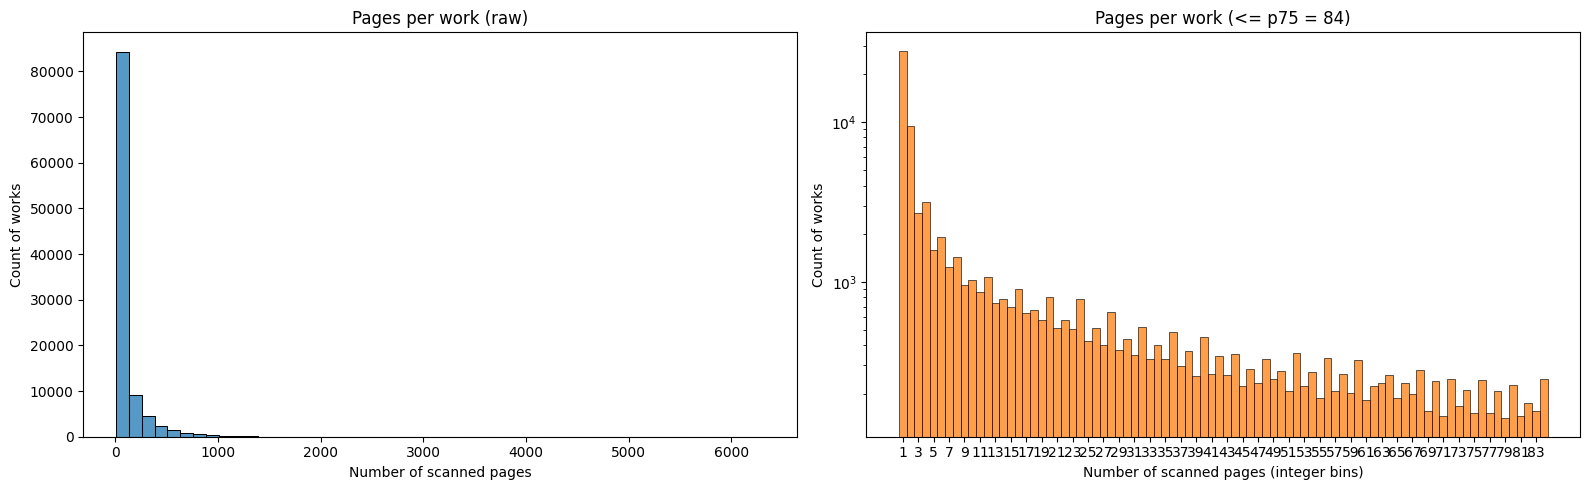

+-------+-----------------+
|summary|       page_count|
+-------+-----------------+
|  count|           104218|
|   mean|84.95028689861635|
| stddev|185.4187259981058|
|    min|                1|
|    max|             6320|
+-------+-----------------+



In [10]:
# Histogram of number of scanned pages per work (based on length of image_ids) using Spark -> pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Defensive checks
if 'works_with_images_no_text_df' not in globals():
    raise NameError("works_with_images_no_text_df is not defined in this notebook session")

if 'image_ids' not in works_with_images_no_text_df.columns:
    raise KeyError("Column 'image_ids' not found in works_with_images_no_text_df")

# Compute page counts with Spark (size of array); treat null array as 0
page_counts_sdf = works_with_images_no_text_df.select(
    F.coalesce(F.size(F.col('image_ids')), F.lit(0)).alias('page_count')
)

# Collect to pandas (only the single column)
page_counts_pd = page_counts_sdf.toPandas()['page_count']

# Basic stats
print('Number of works:', len(page_counts_pd))
print('Min pages:', int(page_counts_pd.min()))
print('Max pages:', int(page_counts_pd.max()))
print('Mean pages:', round(page_counts_pd.mean(), 2))
print('Median pages:', int(page_counts_pd.median()))
print('Std dev:', round(page_counts_pd.std(), 2))
print('Total pages:', int(page_counts_pd.sum()))  # Added total page count
print('\nPercentiles:')
for p in [50, 75, 90, 95, 99]:
    print(f'  p{p}:', int(np.percentile(page_counts_pd, p)))

# p75 clipping and integer binning
p75_threshold = int(np.percentile(page_counts_pd, 75))
integer_bins = range(int(page_counts_pd.min()), p75_threshold + 2)  # +2 because bins are edges

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Raw distribution (may be long-tailed)
sns.histplot(page_counts_pd, bins=50, ax=axes[0], color='#1f77b4')
axes[0].set_title('Pages per work (raw)')
axes[0].set_xlabel('Number of scanned pages')
axes[0].set_ylabel('Count of works')

# Distribution up to p75 with one bin per integer value
p75_data = page_counts_pd[page_counts_pd <= p75_threshold]
sns.histplot(p75_data, bins=integer_bins, ax=axes[1], color='#ff7f0e', discrete=True)
axes[1].set_title(f'Pages per work (<= p75 = {p75_threshold})')
axes[1].set_xlabel('Number of scanned pages (integer bins)')
axes[1].set_ylabel('Count of works')
# log scale y
axes[1].set_yscale('log')

# Optional: annotate counts on top of bars (avoid clutter if too many)
if len(integer_bins) - 1 <= 40:  # only annotate if not too many bars
    for patch in axes[1].patches:
        height = patch.get_height()
        if height > 0:
            axes[1].annotate(f'{int(height)}',
                             (patch.get_x() + patch.get_width() / 2, height),
                             ha='center', va='bottom', fontsize=8, rotation=90)

# Tidy x ticks for p75 panel
if len(integer_bins) - 1 <= 60:
    axes[1].set_xticks(list(range(int(page_counts_pd.min()), p75_threshold + 1)))
    axes[1].tick_params(axis='x', rotation=90 if len(integer_bins) > 30 else 0)
else:
    # Fallback: show every Nth tick
    step = max(1, (len(integer_bins) - 1) // 30)
    ticks = list(range(int(page_counts_pd.min()), p75_threshold + 1, step))
    axes[1].set_xticks(ticks)

plt.tight_layout()
plt.show()

page_counts_sdf.describe().show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'colors'

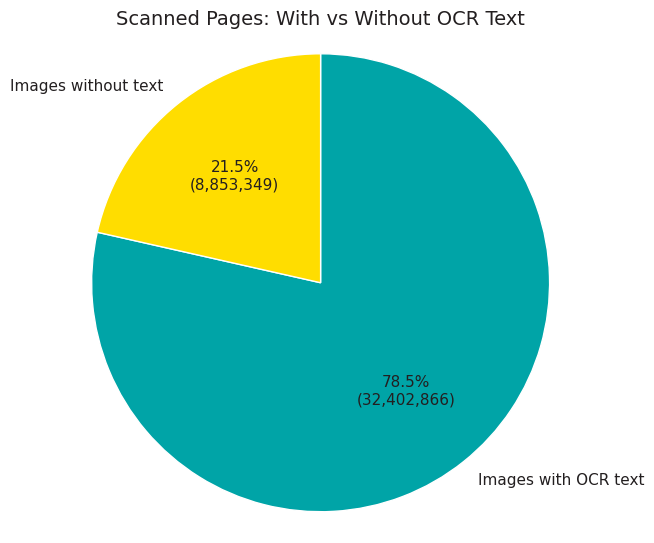

In [12]:
# Pie chart: images with OCR text vs images without text rendering (Wellcome Collection brand colors)
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Wellcome Collection brand-inspired palette (teal & yellow) + optional neutrals
BRAND_TEAL = '#00A4A7'
BRAND_YELLOW = '#FFDD00'
BRAND_DARK = '#231F20'  # near-black used in some assets

# Ensure required DataFrames are available (load from tables if variables missing)
if 'overlap_df' not in globals():
    overlap_df = spark.table('manifests_with_images_and_text')
if 'works_with_images_no_text_df' not in globals():
    works_with_images_no_text_df = spark.table('manifests_with_images_no_text')

# Compute totals safely
with_text_row = overlap_df.select(F.sum(F.size(F.col('image_ids'))).alias('total')).collect()[0]
without_text_row = works_with_images_no_text_df.select(F.sum(F.size(F.col('image_ids'))).alias('total')).collect()[0]

total_image_ids_with_text = int(with_text_row['total'] or 0)
_total_pages_without_text = int(without_text_row['total'] or 0)

# Guard against zero total
grand_total = total_image_ids_with_text + _total_pages_without_text
if grand_total == 0:
    print('No image/page counts available to plot.')
else:
    labels = ['Images with OCR text', 'Images without text']
    sizes = [total_image_ids_with_text, _total_pages_without_text]
    # Use teal for "with text" (positive) and yellow for "without text" (attention)
    colors = [BRAND_TEAL, BRAND_YELLOW]

    fig, ax = plt.subplots(figsize=(6.5, 6.5))
    fig.set_facecolor('white')

    def autopct_fmt(pct):
        absolute = int(round(pct/100.0 * grand_total))
        return f"{pct:.1f}%\n({absolute:,})"

    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        colors=colors,
        autopct=autopct_fmt,
        startangle=90,
        counterclock=False,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.0},
        textprops={'color': BRAND_DARK, 'fontsize': 11}
    )
    ax.axis('equal')
    ax.set_title('Scanned Pages: With vs Without OCR Text', fontsize=14, color=BRAND_DARK)

    # Improve autopct text contrast on yellow slice
    for w, t in zip(wedges, autotexts):
        if w.get_facecolor()[0:3] == plt.colors.to_rgb(BRAND_YELLOW):  # crude match
            t.set_color(BRAND_DARK)
        t.set_fontsize(10)

    plt.show()

    print(f"Images/pages with OCR text   : {total_image_ids_with_text:,}")
    print(f"Images/pages without OCR text: {_total_pages_without_text:,}")
    print(f"Grand total                  : {grand_total:,}")
    pct_without = (_total_pages_without_text / grand_total * 100) if grand_total else 0
    print(f"% without text               : {pct_without:.2f}%")